In [1]:
pip install requests beautifulsoup4 robustbase


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Basmala Kamal\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [4]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("B:/tut-pricing-model/face serums/faceserums_amazon.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""

def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None

    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None

df["rating_numeric"] = df["rating"].apply(clean_rating)

def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["title"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["title", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["title", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df["title"].str.contains("cream", na=False)]
print(df)


                                                 title       price  \
387  2% Salicylic Acid Serum for Face Acne Treatmen...   SAR 64.99   
172  2pcs 10% Niacinamide + 1% Zinc and Hyaluronic ...  SAR 103.00   
281  7Pcs Hyaluronic Acid Micr-oneedling Serum,Hyal...   SAR 45.00   
353  AICHUN BEAUTY Argan Castor Jojoba Tea Tree Oil...   SAR 19.00   
7    AICHUN BEAUTY Serum 99% Vitamin E Collagen Fac...    SAR 9.60   
..                                                 ...         ...   
148  artnaturals Anti-Aging-Set with Vitamin-C Reti...  SAR 144.85   
78   numbuzin No.3 Skin Softening Serum | Pore Care...   SAR 60.00   
149  numbuzin No.5 Goodbye Blemish Serum | Vitamin ...   SAR 69.74   
323  rootree Mobitherapy Repair Serum 50ml - Korean...  SAR 129.90   
363  rootree Mulberry 5D Pore Tightening Clay Mask ...   SAR 99.90   

                 rating                                               link  \
387  5.0 out of 5 stars  https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...   
172

In [5]:
import pandas as pd
from difflib import SequenceMatcher

def is_face_serum(name):
    name = str(name).lower()
    
    # Keywords that must appear or match closely
    keywords = [
        "face serum", "facial serum", "serum", 
        "brightening serum", "anti-aging serum", 
        "anti wrinkle serum", "vitamin c serum", 
        "hyaluronic acid serum", "niacinamide serum"
    ]

    # Optional: Exclude unrelated serums or products
    exclude_keywords = [
        "hair serum", "eyelash serum", "beard serum", "body serum", 
        "booster", "toner", "mist", "deodorant", "sunscreen", "cream"
    ]

    for exclude in exclude_keywords:
        if exclude in name:
            return False

    for keyword in keywords:
        if keyword in name or SequenceMatcher(None, keyword, name).ratio() > 0.7:
            return True

    return False

# Example Usage on DataFrame
df = df[df['title'].apply(is_face_serum)]
df.reset_index(drop=True, inplace=True)


In [7]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two|2pcs)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r"\b\d+\s*(bottles|packs?|count|piece|pieces)\b", title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df["title"].apply(is_multi_item)

# Split the DataFrame
sets_df = df[mask_sets].copy()
df = df[~mask_sets].copy()

# Optional: Reset index if needed
sets_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
# Only compute if both volume and price are available
df["price_per_volume"] = df.apply(
    lambda row: row["price_numeric"] / row["volume"]
    if pd.notna(row["volume"]) and pd.notna(row["price_numeric"]) and row["price_numeric"] > 0
    else None,
    axis=1
)


In [9]:
print(df["price_numeric"].describe())


count    211.000000
mean      60.110948
std       32.768615
min        9.600000
25%       39.425000
50%       52.000000
75%       71.145000
max      240.000000
Name: price_numeric, dtype: float64


In [10]:
print(df["price_per_volume"].describe())


count    148.000000
mean       2.031653
std        1.200116
min        0.175000
25%        1.248333
50%        1.733833
75%        2.616917
max        8.000000
Name: price_per_volume, dtype: float64


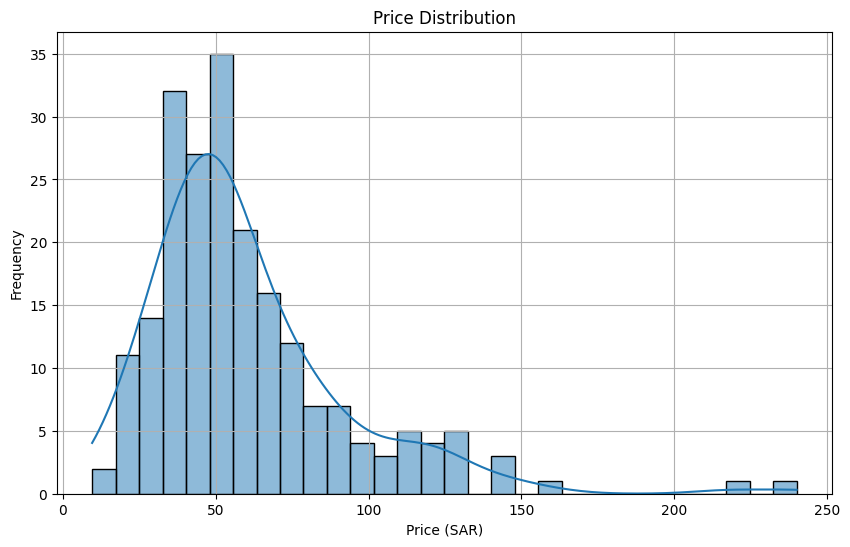

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [12]:
df_cleaned = df.dropna(subset=["title", "price_numeric","price_per_volume"])
df_cleaned.shape

(148, 8)

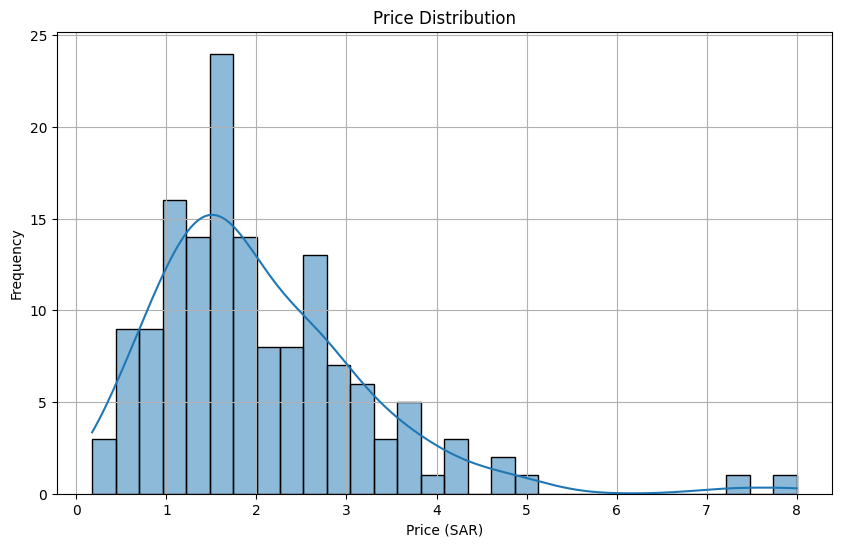

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned["price_per_volume"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_cleaned = df_cleaned.copy()
df_cleaned["price_log"] = np.log1p(df_cleaned["price_per_volume"])

# Then standard scale
scaler = StandardScaler()
df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])


C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 

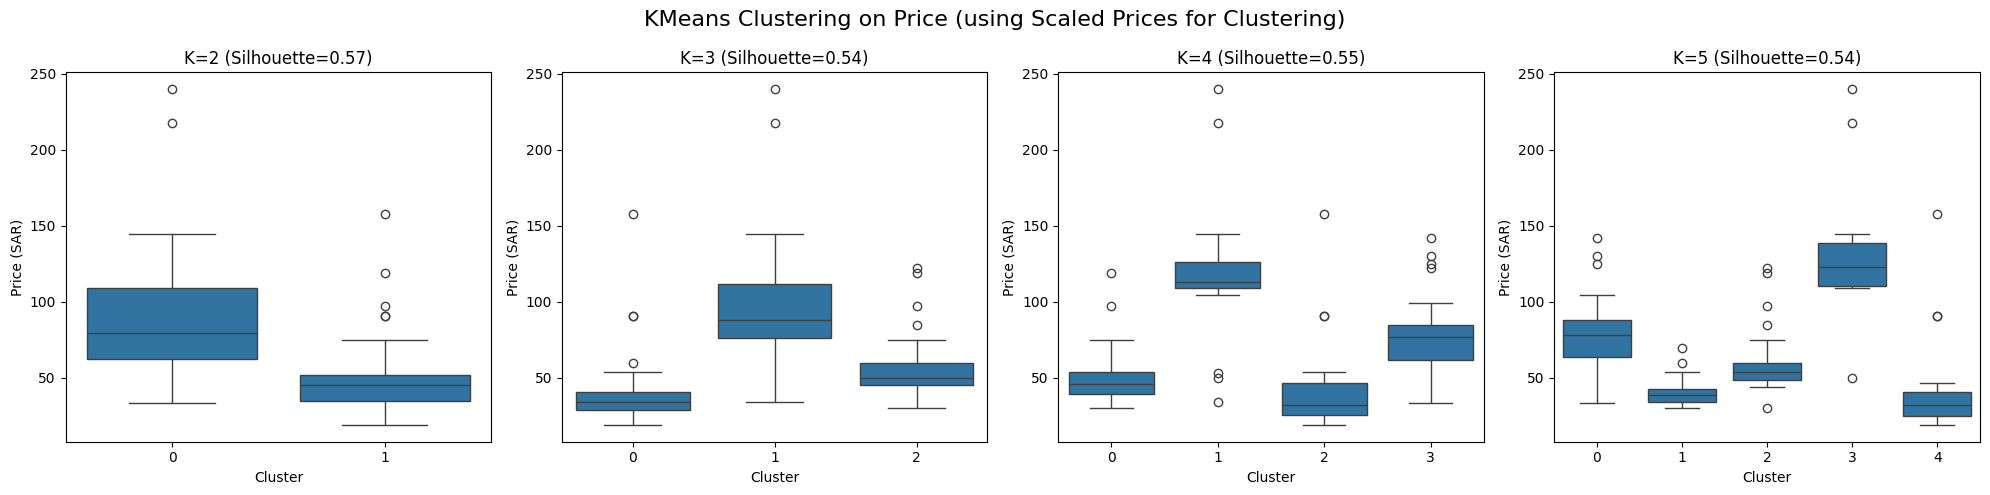

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


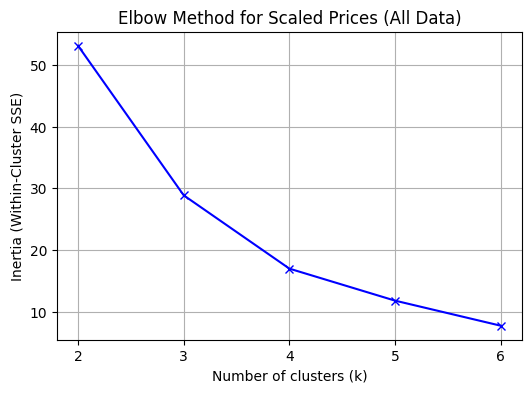

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Reassign cluster labels based on ascending mean price
df_cleaned = df_cleaned.copy()
df_cleaned["temp_cluster"] = kmeans.labels_

# Calculate mean price per cluster
cluster_means = (
    df_cleaned.groupby("temp_cluster")["price_per_volume"]
    .mean()
    .sort_values()
    .reset_index()
)

# Create a mapping from original label to sorted label (e.g. {2: 0, 0: 1, 1: 2})
label_mapping = {row["temp_cluster"]: new_label for new_label, row in cluster_means.iterrows()}

# Apply new labels
df_cleaned["final_cluster"] = df_cleaned["temp_cluster"].map(label_mapping)
df_cleaned.drop(columns=["temp_cluster"], inplace=True)

# 4. Show actual price statistics per sorted cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["price_per_volume"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count      mean       min       max
final_cluster                                     
0                 36  0.832756  0.175000  1.200000
1                 65  1.715216  1.217333  2.376667
2                 47  3.387582  2.485333  8.000000


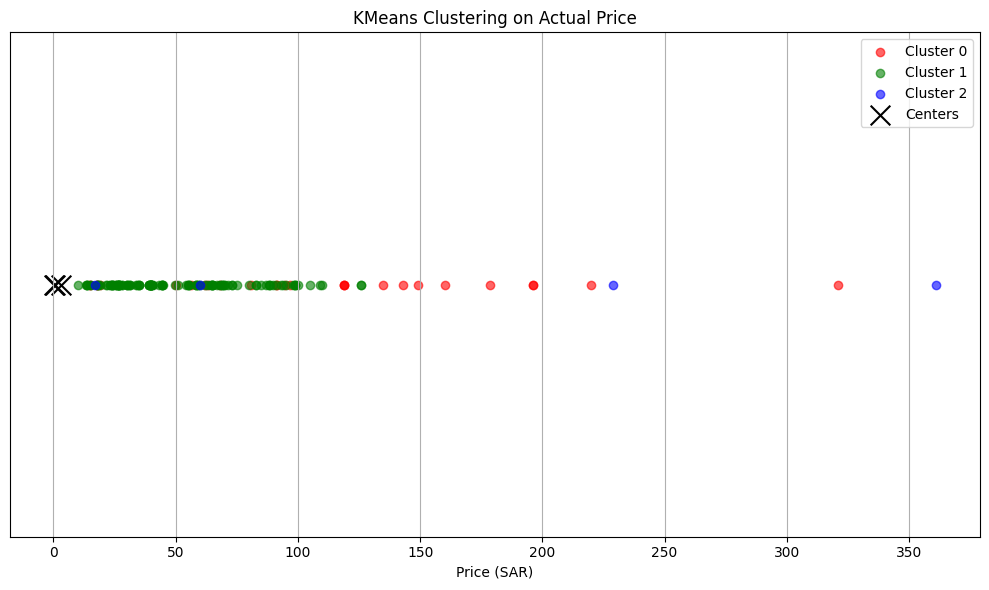

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Make sure 'price_numeric' exists in df_cleaned
df_cleaned = df_cleaned.copy()

# Prepare actual price data
X_price = df_cleaned[["price_per_volume"]].values

# Run KMeans on actual prices
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)
df_cleaned["final_cluster"] = kmeans.labels_

# Plotting clusters based on actual price
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']

for cluster in range(k):
    cluster_points = df_cleaned[df_cleaned["final_cluster"] == cluster]
    plt.scatter(cluster_points["price_numeric"], [0] * len(cluster_points),
                label=f"Cluster {cluster}", alpha=0.6, color=colors[cluster])

# Cluster centers (actual price values)
centers = kmeans.cluster_centers_.flatten()
plt.scatter(centers, [0] * k, c='black', s=200, marker='x', label='Centers')

# Plot config
plt.title("KMeans Clustering on Actual Price")
plt.xlabel("Price (SAR)")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
low = df_cleaned[
    (df_cleaned["final_cluster"] == 0)
]
low

,title,price,rating,link,price_numeric,rating_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
2,AICHUN BEAUTY Argan Castor Jojoba Tea Tree Oil...,SAR 19.00,3.6 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,19.00,3.6,30.000000,0.633333,0.490623,-1.536642,1,0,2,4,0
5,AS ASHLEY SHINE Niacinamide Pure Serum 2 in 1 ...,SAR 91.00,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,91.00,NaN,520.000000,0.175000,0.161268,-2.454047,1,0,2,4,0
7,AXIS-Y Dark Spot Correcting Glow Serum 50ml,SAR 36.02,4.2 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,36.02,4.2,50.000000,0.720400,0.542557,-1.391983,1,0,2,4,0
8,Advanced Clinicals Hyaluronic Acid Serum 1.75 Oz,SAR 51.64,4.2 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,51.64,4.2,51.753625,0.997805,0.692049,-0.975579,1,0,2,1,0
9,Advanced Clinicals Retinol Serum 1.75 Oz,SAR 48.57,4.2 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,48.57,4.2,51.753625,0.938485,0.661907,-1.059538,1,0,2,1,0
13,Aqualogica Radiance+ Juicy Dew Drops Illuminat...,SAR 19.99,3.7 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,19.99,3.7,30.000000,0.666333,0.510626,-1.480926,1,0,2,4,0
14,Ashley Shine Niacinamide Pure Serum: For Face ...,SAR 90.40,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,90.40,4.3,250.000000,0.361600,0.308660,-2.043491,1,0,2,4,0
46,"Azonee White Truffle Primer Spray Serum, Vegan...",SAR 44.79,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,44.79,NaN,99.958430,0.448086,0.370243,-1.871956,1,0,2,4,0
52,"Boto-x Stock Solution Facial Serum 60ml, Boto-...",SAR 46.90,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,46.90,3.8,60.000000,0.781667,0.577549,-1.294513,1,0,2,4,0
64,DERMA CLINICALS Copper Peptide + Matrixyl 3000...,SAR 157.91,5.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,157.91,5.0,236.588000,0.667447,0.511294,-1.479064,1,0,2,4,0


In [21]:
mid = df_cleaned[
    (df_cleaned["final_cluster"] == 1)
]
mid

,title,price,rating,link,price_numeric,rating_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
12,Anua 10% Niacinamide+ 4% Tranexamic Acid Serum...,SAR 60.00,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,60.00,4.3,30.000000,2.000000,1.098612,0.156887,0,2,3,2,1
27,"Azonee Fruit Acid Face Serum, Dark Spot Remove...",SAR 46.46,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,46.46,NaN,30.000000,1.548667,0.935570,-0.297260,1,2,0,2,1
29,"Azonee Hyaluronic Acid Serum for Face, Face Se...",SAR 47.99,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,47.99,NaN,30.000000,1.599667,0.955383,-0.242072,1,2,0,2,1
36,"Azonee Rose Face Serum, Moisturizing Face Seru...",SAR 29.90,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,29.90,NaN,17.744100,1.685067,0.987706,-0.152039,1,2,0,2,1
40,Azonee Vitamin C Face Serum - Antioxidant Faci...,SAR 59.00,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,59.00,NaN,30.000000,1.966667,1.087439,0.125764,0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Zayn & Myza Hyaluronic Acid 1.5% with 24k Gold...,SAR 55.99,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,55.99,3.8,30.000000,1.866333,1.053034,0.029930,1,2,0,2,1
204,Zayn&Myza Retinol Face Serum 30ML,SAR 61.00,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,61.00,3.8,30.000000,2.033333,1.109662,0.187666,0,2,3,2,1
205,Zayn&Myza Tea Tree & Salyicylic Acid Face Seru...,SAR 56.06,3.7 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,56.06,3.7,30.000000,1.868667,1.053847,0.032196,1,2,0,2,1
206,Zayn&Myza Vitamin C Face Serum 30ML,SAR 56.06,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,56.06,3.8,30.000000,1.868667,1.053847,0.032196,1,2,0,2,1


In [23]:
high = df_cleaned[
    (df_cleaned["final_cluster"] == 2)
]
high

,title,price,rating,link,price_numeric,rating_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
6,ASTERWOOD NATURALS Matrixyl 3000 + Argireline ...,SAR 126.00,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,126.00,4.4,29.00000,4.344828,1.676129,1.765537,0,1,1,3,2
10,Aitnaturals Anti-Aging Serum Set (Each 30ml) |...,SAR 80.94,4.5 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,80.94,4.5,30.00000,2.698000,1.307792,0.739549,0,1,3,0,2
15,Aveeno Calm + Restore Triple Oat Hydrating Fac...,SAR 77.00,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,77.00,4.4,29.57350,2.603682,1.281956,0.667584,0,1,3,0,2
17,"Azonee Bakuchiol & Retinol Anti-Aging Serum, H...",SAR 90.66,5.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,90.66,5.0,29.57350,3.065582,1.402557,1.003513,0,1,3,0,2
30,"Azonee Hyaluronic Acid Serum, 15ml Pure Hyalur...",SAR 41.95,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,41.95,4.4,15.00000,2.796667,1.334123,0.812894,0,1,3,0,2
44,"Azonee Vitamin C Facial Serum, Moisturizing Fa...",SAR 44.10,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,44.10,NaN,17.74410,2.485333,1.248564,0.574571,0,1,3,0,2
48,"Bakuchiol Serum, Bakuchiol Face Serum, Bakuchi...",SAR 79.55,5.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,79.55,5.0,30.00000,2.651667,1.295184,0.704429,0,1,3,0,2
53,COSRX The Niacinamide 15 Serum 20ml,SAR 57.27,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,57.27,4.4,20.00000,2.863500,1.351574,0.861500,0,1,3,0,2
56,CeraVe Resurfacing RETINOL Serum For Face with...,SAR 85.00,4.5 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,85.00,4.5,30.00000,2.833333,1.343735,0.839666,0,1,3,0,2
57,CeraVe Resurfacing Retinol Serum with Ceramide...,SAR 80.00,4.5 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,80.00,4.5,30.00000,2.666667,1.299283,0.715847,0,1,3,0,2


KMeans clusters: 3
DBSCAN clusters: 9 (+ noise)


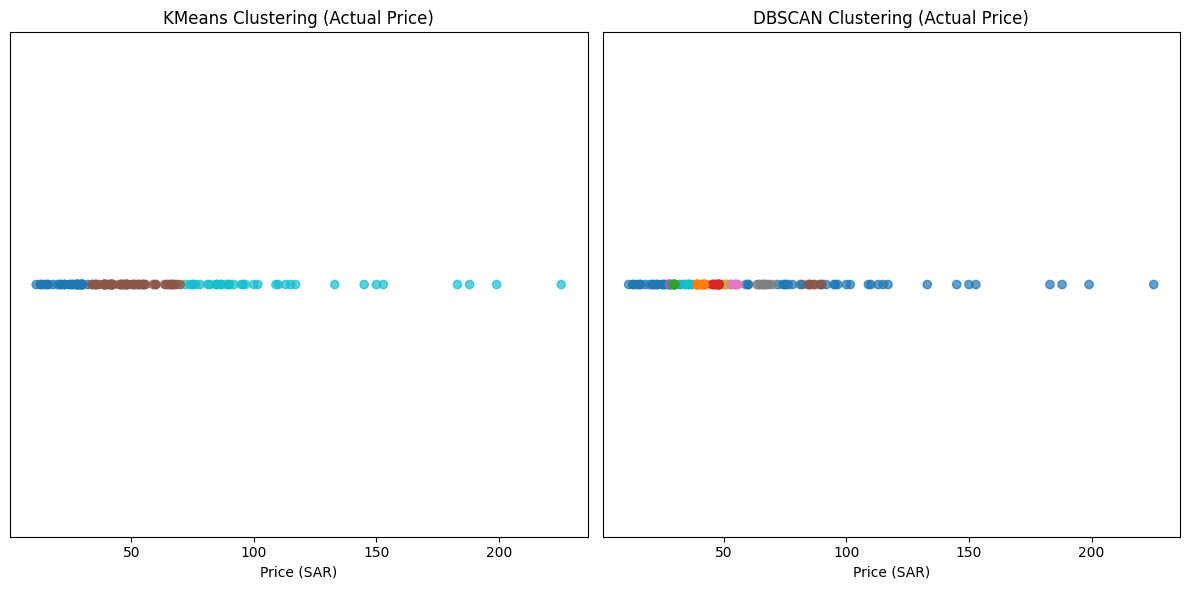

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. Run DBSCAN on existing scaled price
dbscan = DBSCAN(eps=0.05, min_samples=5)
df_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])

# 2. Compare number of clusters
n_kmeans = df_cleaned["final_cluster"].nunique()
n_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)

print(f"KMeans clusters: {n_kmeans}")
print(f"DBSCAN clusters: {n_dbscan} (+ noise)")

# 3. Visual comparison
plt.figure(figsize=(12, 6))

# KMeans plot
plt.subplot(1, 2, 1)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

# DBSCAN plot
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["dbscan_cluster"], cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

plt.tight_layout()
plt.show()
"""

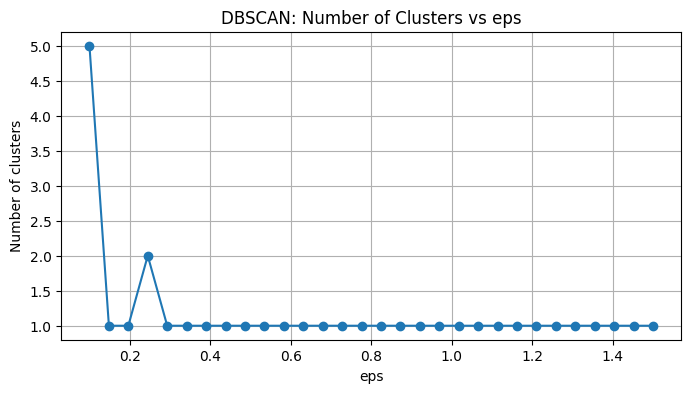

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

eps_values = np.linspace(0.1, 1.5, 30)
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_cleaned[["price_scaled"]])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title("DBSCAN: Number of Clusters vs eps")
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid(True)
plt.show()
"""